In [1]:
! pip install fuzzywuzzy python-Levenshtein deep-translator

In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import nltk
import difflib
from fuzzywuzzy import fuzz

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from transformers import (
    BertTokenizerFast,
    BertForTokenClassification,
    get_scheduler
)
from torch.optim import AdamW
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
from deep_translator import GoogleTranslator

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# IHQID_1mg_train_path = "indic-health-demo/Dataset/IHQID-1mg/train.csv"
# IHQID_1mg_test_path = "indic-health-demo/Dataset/IHQID-1mg/test.csv"

IHQID_WebMD_train_path = "indic-health-demo/Dataset/IHQID-WebMD/train.csv"
IHQID_WebMD_test_path = "indic-health-demo/Dataset/IHQID-WebMD/test.csv"


IHQID_train = pd.read_csv(IHQID_WebMD_train_path)[['question_hindi', 'disease_hindi', 'drug_hindi', 'treatment_hindi']]
IHQID_test = pd.read_csv(IHQID_WebMD_test_path)[['question_hindi', 'disease_hindi', 'drug_hindi', 'treatment_hindi']]


In [4]:
google_translator = GoogleTranslator(source='hi', target='en')

for index in tqdm(range(len(IHQID_train['question_hindi']))):
    IHQID_train['question_hindi'][index] = google_translator.translate(IHQID_train['question_hindi'][index])
    
    if type(IHQID_train['disease_hindi'][index]) is not float:
        IHQID_train['disease_hindi'][index] = google_translator.translate(IHQID_train['disease_hindi'][index])
        
    if type(IHQID_train['drug_hindi'][index]) is not float:
        IHQID_train['drug_hindi'][index] = google_translator.translate(IHQID_train['drug_hindi'][index])
        
    if type(IHQID_train['treatment_hindi'][index]) is not float:
        IHQID_train['treatment_hindi'][index] = google_translator.translate(IHQID_train['treatment_hindi'][index])
    
for index in tqdm(range(len(IHQID_test['question_hindi']))):
    IHQID_test['question_hindi'][index] = google_translator.translate(IHQID_test['question_hindi'][index])
    
    if type(IHQID_test['disease_hindi'][index]) is not float:
        IHQID_test['disease_hindi'][index] = google_translator.translate(IHQID_test['disease_hindi'][index])
        
    if type(IHQID_test['drug_hindi'][index]) is not float:
        IHQID_test['drug_hindi'][index] = google_translator.translate(IHQID_test['drug_hindi'][index])
        
    if type(IHQID_test['treatment_hindi'][index]) is not float:
        IHQID_test['treatment_hindi'][index] = google_translator.translate(IHQID_test['treatment_hindi'][index])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 241/241 [04:33<00:00,  1.13s/it]


# GENERATING TAGS

In [5]:
def get_common_sequence(tokenized_sentence, tokenized_entity, entity, tag_list):
    contiguous_indices = {
        "similarity": 0.0,
        "index_start": -1,
        "index_end": -1
    }
    target_length = len(tokenized_entity)
    sentence_length = len(tokenized_sentence)

    for i in range(sentence_length - target_length + 1):
        # Target length = target length
        fuzz_ratio = fuzz.ratio(tokenized_entity, tokenized_sentence[i:i + target_length])
        
        if fuzz_ratio >= 80 and contiguous_indices["similarity"] < fuzz_ratio:
            contiguous_indices["similarity"] = fuzz_ratio
            contiguous_indices["index_start"] = i
            contiguous_indices["index_end"] = i + target_length - 1
            
        # Target length = target length - 1
        fuzz_ratio = fuzz.ratio(tokenized_entity, tokenized_sentence[i:i + target_length - 1])
        
        if fuzz_ratio >= 80 and contiguous_indices["similarity"] < fuzz_ratio:
            # To take care of when tokenization increased the number of tokens [Eg - (1000mg/ mg) vs (1000mg/mg)]
            contiguous_indices["similarity"] = fuzz_ratio
            contiguous_indices["index_start"] = i
            contiguous_indices["index_end"] = i + target_length - 2
            
    tag_list[contiguous_indices["index_start"]] = "B-" + entity
    for index in range(contiguous_indices["index_start"] + 1, contiguous_indices["index_end"] + 1):
        tag_list[index] = "I-" + entity

In [6]:
IHQID_train['tags_hindi'] = IHQID_train['question_hindi']

for i in range(len(IHQID_train)):
    
    tokenized_sentence = word_tokenize(IHQID_train['question_hindi'][i].lower())
    
    tag_list = ['O' for token in tokenized_sentence]
    
    tokenized_diseases = []
    tokenized_drugs = []
    tokenized_treatments = []
    
    if type(IHQID_train['disease_hindi'][i]) is not float:
        tokenized_diseases = [word_tokenize(entity.lower()) for entity in IHQID_train['disease_hindi'][i].split(',')]
        for tokenized_disease in tokenized_diseases:
            get_common_sequence(tokenized_sentence, tokenized_disease, "disease", tag_list)
    else:
        assert(math.isnan(IHQID_train['disease_hindi'][i]))
        
    if type(IHQID_train['drug_hindi'][i]) is not float:
        tokenized_drugs = [word_tokenize(entity.lower()) for entity in IHQID_train['drug_hindi'][i].split(',')]
        for tokenized_drug in tokenized_drugs:
            get_common_sequence(tokenized_sentence, tokenized_drug, "drug", tag_list)
    else:
        assert(math.isnan(IHQID_train['drug_hindi'][i]))
    
    if type(IHQID_train['treatment_hindi'][i]) is not float:
        tokenized_treatments = [word_tokenize(entity.lower()) for entity in IHQID_train['treatment_hindi'][i].split(',')]
        for tokenized_treatment in tokenized_treatments:
            get_common_sequence(tokenized_sentence, tokenized_treatment, "treatment", tag_list)
    else:
        assert(math.isnan(IHQID_train['treatment_hindi'][i]))

    IHQID_train['question_hindi'][i] = tokenized_sentence
    IHQID_train['tags_hindi'][i] = tag_list

In [7]:
IHQID_test['tags_hindi'] = IHQID_test['question_hindi']

for i in range(len(IHQID_test)):
    
    tokenized_sentence = word_tokenize(IHQID_test['question_hindi'][i].lower())
    
    tag_list = ['O' for token in tokenized_sentence]
    
    tokenized_diseases = []
    tokenized_drugs = []
    tokenized_treatments = []
    
    if type(IHQID_test['disease_hindi'][i]) is not float:
        tokenized_diseases = [word_tokenize(entity.lower()) for entity in IHQID_test['disease_hindi'][i].split(',')]
        for tokenized_disease in tokenized_diseases:
            get_common_sequence(tokenized_sentence, tokenized_disease, "disease", tag_list)
    else:
        assert(math.isnan(IHQID_test['disease_hindi'][i]))
        
    if type(IHQID_test['drug_hindi'][i]) is not float:
        tokenized_drugs = [word_tokenize(entity.lower()) for entity in IHQID_test['drug_hindi'][i].split(',')]
        for tokenized_drug in tokenized_drugs:
            get_common_sequence(tokenized_sentence, tokenized_drug, "drug", tag_list)
    else:
        assert(math.isnan(IHQID_test['drug_hindi'][i]))
    
    if type(IHQID_test['treatment_hindi'][i]) is not float:
        tokenized_treatments = [word_tokenize(entity.lower()) for entity in IHQID_test['treatment_hindi'][i].split(',')]
        for tokenized_treatment in tokenized_treatments:
            get_common_sequence(tokenized_sentence, tokenized_treatment, "treatment", tag_list)
    else:
        assert(math.isnan(IHQID_test['treatment_hindi'][i]))

    IHQID_test['question_hindi'][i] = tokenized_sentence
    IHQID_test['tags_hindi'][i] = tag_list


In [8]:
IHQID_train.head()

,question_hindi,disease_hindi,drug_hindi,treatment_hindi,tags_hindi
0,"[what, is, nystatin, prescribed, for, ?]",NaN,nystatin,NaN,"[O, O, B-drug, O, O, O]"
1,"[can, douching, after, sex, prevent, me, from,...",pregnant,NaN,NaN,"[O, O, O, O, O, O, O, O, B-disease, O]"
2,"[does, percocet, cause, weight, gain]",weight gain,Percocet,NaN,"[O, B-drug, O, B-disease, I-disease]"
3,"[does, 2, or, 2, 1/2, glasses, of, wine, a, da...",high blood pressure,NaN,NaN,"[O, O, O, O, O, O, O, O, O, O, O, B-disease, I..."
4,"[can, too, much, buttermilk, cause, thrush, ?]",thrush,NaN,NaN,"[O, O, O, O, O, B-disease, O]"


In [9]:
IHQID_train.tail()

,question_hindi,disease_hindi,drug_hindi,treatment_hindi,tags_hindi
715,"[would, the, affordable, care, act, require, a...",pregnancy,NaN,NaN,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-d..."
716,"[how, can, i, use, duct, tape, to, get, rid, o...",warts,NaN,NaN,"[O, O, O, O, O, O, O, O, O, O, B-disease, O]"
717,"[what, facial, exercises, can, be, done, to, h...",Bell's palsy facial paralysis,NaN,facial exercises,"[O, B-treatment, I-treatment, O, O, O, O, O, O..."
718,"[is, prenatal, ultrasound, safe, ?]",NaN,NaN,prenatal ultrasound,"[O, B-treatment, I-treatment, O, O]"
719,"[how, can, i, reduce, inguinal, hernia, sympto...",inguinal hernia,NaN,surgery,"[O, O, O, O, B-disease, I-disease, O, O, B-tre..."


In [10]:
IHQID_test.head()

,question_hindi,disease_hindi,drug_hindi,treatment_hindi,tags_hindi
0,"[how, common, is, pregnancy, after, hysterecto...",pregnant,NaN,Hysterectomy,"[O, O, O, B-disease, O, B-treatment, O]"
1,"[how, effective, is, generic, thyroid, medicat...",NaN,general thyroid medication,NaN,"[O, O, O, B-drug, I-drug, I-drug, O]"
2,"[is, singulair, a, corticosteroid, ?]",NaN,"singular, corticosteroid",NaN,"[O, B-drug, O, B-drug, O]"
3,"[can, you, take, advil, with, homeopathic, air...",NaN,"Advil, Homeopathic Ear Drops",NaN,"[O, O, O, B-drug, O, B-drug, I-drug, I-drug, O]"
4,"[is, bell, 's, palsy, contagious, ?]",bell's palsy,NaN,NaN,"[O, B-disease, I-disease, I-disease, O, O]"


In [11]:
IHQID_test.tail()

,question_hindi,disease_hindi,drug_hindi,treatment_hindi,tags_hindi
236,"[how, will, obamacare, affect, medicare, recip...",NaN,NaN,NaN,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
237,"[what, is, the, role, of, mptp, in, the, study...",Parkinson's disease,NaN,mptp,"[O, O, O, O, O, B-treatment, O, O, O, O, B-dis..."
238,"[is, botox, safe, to, use, for, frown, lines, ...","frown lines, wrinkles",botox,NaN,"[O, B-drug, O, O, O, O, B-disease, I-disease, ..."
239,"[when, will, i, have, an, ultrasound, during, ...",pregnancy,NaN,ultrasound,"[O, O, O, O, O, B-treatment, O, B-disease, O]"
240,"[does, nucinta, have, tylenol, ?]",NaN,"Nucinta, Tylenol",NaN,"[O, B-drug, O, B-drug, O]"


# TRAINING AND TESTING

In [12]:
label__ = {
    'O': 0,
    'B-treatment': 1,
    'I-treatment': 2,
    'B-disease': 3,
    'I-disease': 4,
    'B-drug': 5,
    'I-drug': 6
}

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

model_checkpoint = "emilyalsentzer/Bio_ClinicalBERT"

hyper_parameters = {
    'batch_size': 8,
    'lr': 3e-5,
    'epochs': 10
}

cuda


In [14]:
tokenizer = BertTokenizerFast.from_pretrained(model_checkpoint, add_prefix_space=True)

In [15]:
def process_queries(question, tag): 
    
    tokenized_input = tokenizer(question, max_length=300, padding='max_length', truncation=True, is_split_into_words=True)
    word_ids = tokenized_input.word_ids()
    for i, label in enumerate(word_ids):
        if label is None:
            word_ids[i] = 7
        else:
            word_ids[i] = label__[tag[label]]
    tokenized_input["labels"] = word_ids
    return tokenized_input

In [16]:
encoded_input_train = {
    'input_ids': [],
    'attention_mask': [],
    'tags_hindi': []
}

for index in range(len(IHQID_train['question_hindi'])):
    process_output = process_queries(IHQID_train['question_hindi'][index], IHQID_train['tags_hindi'][index])
    encoded_input_train['input_ids'].append(process_output['input_ids'])
    encoded_input_train['attention_mask'].append(process_output['attention_mask'])
    encoded_input_train['tags_hindi'].append(process_output['labels'])

encoded_input_test = {
    'input_ids': [],
    'attention_mask': [],
    'tags_hindi': []
}

for index in range(len(IHQID_test['question_hindi'])):
    process_output = process_queries(IHQID_test['question_hindi'][index], IHQID_test['tags_hindi'][index])
    encoded_input_test['input_ids'].append(process_output['input_ids'])
    encoded_input_test['attention_mask'].append(process_output['attention_mask'])
    encoded_input_test['tags_hindi'].append(process_output['labels'])

train_dataloader = DataLoader(
    TensorDataset(
        torch.tensor(encoded_input_train['input_ids']).to(device),
        torch.tensor(encoded_input_train['attention_mask']).to(device),
        torch.tensor(encoded_input_train['tags_hindi']).to(device)
    ),
    batch_size=hyper_parameters['batch_size']
)

test_dataloader = DataLoader(
    TensorDataset(
        torch.tensor(encoded_input_test['input_ids']).to(device),
        torch.tensor(encoded_input_test['attention_mask']).to(device),
        torch.tensor(encoded_input_test['tags_hindi']).to(device)
    ),
    batch_size=hyper_parameters['batch_size']
)


In [17]:
model = BertForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(label__) + 1
)
model.to(device)

optimizer = AdamW(
    model.parameters(),
    lr=hyper_parameters['lr']
)

lr_scheduler = get_scheduler(
  "linear",
  optimizer=optimizer,
  num_warmup_steps=0,
  num_training_steps=hyper_parameters['epochs'] * len(train_dataloader)
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
model.train()

updater = tqdm(range(hyper_parameters['epochs']))
for epoch in updater:
    total_train_loss = 0.0
    for batch in train_dataloader:
        
        optimizer.zero_grad()
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2],
        }
        
        outputs = model(**inputs)
        
        loss = outputs.loss
        loss.backward()
        
        optimizer.step()
        lr_scheduler.step()
        
        total_train_loss += loss.item()
    
    print("Epoch:", epoch + 1, " - Training Loss:", round(total_train_loss / len(train_dataloader), 4))


# Didn't have much time to implement early stopping. So, saving the model at the end of all epochs.
torch.save(model.state_dict(), f'ee_dtrans_hi.model')


 10%|███████████████▌                                                                                                                                           | 1/10 [00:14<02:14, 14.91s/it]

Epoch: 1  - Training Loss: 0.1517


 20%|███████████████████████████████                                                                                                                            | 2/10 [00:29<01:58, 14.84s/it]

Epoch: 2  - Training Loss: 0.0309


 30%|██████████████████████████████████████████████▌                                                                                                            | 3/10 [00:44<01:44, 14.86s/it]

Epoch: 3  - Training Loss: 0.0216


 40%|██████████████████████████████████████████████████████████████                                                                                             | 4/10 [00:59<01:29, 14.93s/it]

Epoch: 4  - Training Loss: 0.0158


 50%|█████████████████████████████████████████████████████████████████████████████▌                                                                             | 5/10 [01:14<01:15, 15.03s/it]

Epoch: 5  - Training Loss: 0.0119


 60%|█████████████████████████████████████████████████████████████████████████████████████████████                                                              | 6/10 [01:30<01:00, 15.09s/it]

Epoch: 6  - Training Loss: 0.0092


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 7/10 [01:45<00:45, 15.13s/it]

Epoch: 7  - Training Loss: 0.0075


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 8/10 [02:00<00:30, 15.17s/it]

Epoch: 8  - Training Loss: 0.006


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 9/10 [02:15<00:15, 15.20s/it]

Epoch: 9  - Training Loss: 0.0053


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:31<00:00, 15.11s/it]

Epoch: 10  - Training Loss: 0.0048


In [19]:
model.eval()

prediction = []
gold_label = []

extra_appended_tokens = 0

for indexer, batch in enumerate(test_dataloader):

    inputs = {
        'input_ids': batch[0],
        'attention_mask': batch[1],
        'labels': batch[2],
    }

    with torch.no_grad():
        outputs = model(**inputs)


    gold_label_cpu = inputs['labels'].cpu().numpy()
    logits_vector = outputs.logits.detach().cpu().numpy()

    assert(len(gold_label_cpu) == len(logits_vector))

    for index in range(len(logits_vector)):
        prediction_vector = []
        for iterator__ in logits_vector[index].argmax(axis=1):
            if iterator__ != 7:
                prediction_vector.append(iterator__)
                prediction.append(iterator__)
        
        gold_label_vector = []
        for iterator__ in gold_label_cpu[index]:
            if iterator__ != 7:
                gold_label_vector.append(iterator__)
                gold_label.append(iterator__)
        
        # There are some cases (only observed once) when there was one mismatch in vector of gold label and prediction
        # To overcome that, for each tokenized sentence, append 0 to signify it not be classified as any of the entity
        while len(gold_label) < len(prediction):
            extra_appended_tokens += 1
            gold_label.append(0)
        
        while len(prediction) < len(gold_label):
            extra_appended_tokens += 1
            prediction.append(0)

print("Number of extra appended tokens : ", extra_appended_tokens)
print(classification_report(gold_label, prediction))

Number of extra appended tokens :  1
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      2510
           1       0.74      0.78      0.76       113
           2       0.67      0.52      0.59        61
           3       0.76      0.76      0.76       292
           4       0.60      0.67      0.63       112
           5       0.86      0.84      0.85       283
           6       0.73      0.68      0.71        44

    accuracy                           0.90      3415
   macro avg       0.76      0.74      0.75      3415
weighted avg       0.90      0.90      0.90      3415



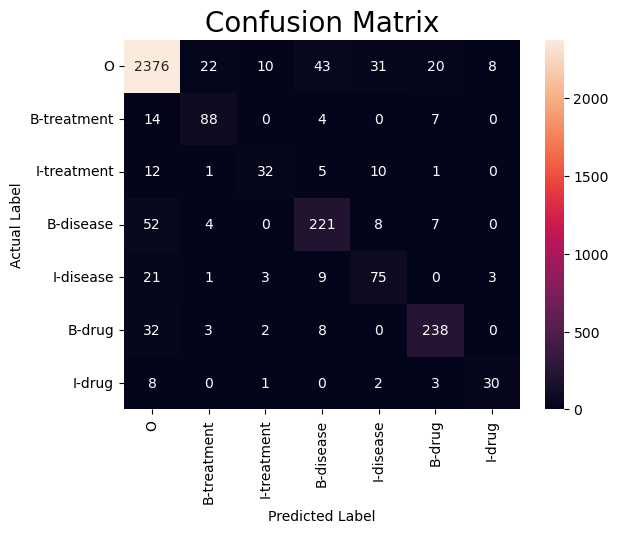

In [20]:
# Compute the confusion matrix
cm = confusion_matrix(gold_label, prediction)

# Plot the confusion matrix.
sns.heatmap(
    cm,
    annot=True,
    fmt='g',
    xticklabels=['O', 'B-treatment', 'I-treatment', 'B-disease', 'I-disease', 'B-drug', 'I-drug'],
    yticklabels=['O', 'B-treatment', 'I-treatment', 'B-disease', 'I-disease', 'B-drug', 'I-drug']
)
plt.xlabel('Predicted Label', fontsize=10)
plt.ylabel('Actual Label', fontsize=10)
plt.title('Confusion Matrix', fontsize=20)
plt.show()